In [1]:
from __future__ import print_function, division, unicode_literals
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from AVIReader import * # Reads an avi file and returns a sidpy dataset with meta data
from MonaPathParse import * # Code written to splice files from Mona's experiments, NOT UNIVERSAL 

import os
import sidpy
import sys
import pyNSID
import dask as da
import pandas as pd

In [2]:
#After importing the toolboxes above, specify the location of the video file that you want to import and analyze

# Specifies the path location of the experimental video on the hard drive from Mona.
# This path variable will be analyzed to capture metadate about the experiment.
#files = os.listdir("/Volumes/MK_Device_4/Microbial/Good_Final_videos/YR343_030422/YR343_MS_040422/0_H")
#print(files)

filenames = ['Channel_3_0.avi','Channel_3_7_5.avi','Channel_3_15.avi','Channel_3_22_5.avi', \
            'Channel_3_30.avi']
directory = ['8_H','6_H','4_H','2_H','0_H']
media1 = 'R2A'
media2 = 'MS'


dsets = []
ds_titles = []

for i in range (len(filenames)):
    path = "/Volumes/MK_Device_5/Microbial/8H_Migration_Studies/AP07_032422/AP07_MS/"+directory[0]+'/' \
    + filenames[i]
    path_dict = MonaPathParse(path)
    path_dict = path_dict.read()
    path_dict['Operator'] = 'Muneeba Khalid'
    path_dict['Objective'] = '20x'
    path_dict['Microscope'] = 'Zeiss Axioscope w/ Phase Contrast'
    path_dict['PhaseSettings'] = 'Y'
    path_dict['Camera'] = 'Infinity3-1UC'
    path_dict['AcquisitionSoftware'] = 'Infinity Capture'
    path_dict['Gain'] = '2'
    path_dict['ExposureTime'] = 'not recorded'
    path_dict['um_per_pixel_scale']  = float(440/687)

    dset = AVIReader(path, path_dict)
    ds = dset.read()
    ds.title = ds.metadata['Species']+'_'+ds.metadata['Media']+\
        '_'+ds.metadata['Timepoint']+ds.metadata['Time_Units']+'_'+ds.metadata['Channel Location']+'mm'
    ds_titles.append(ds.title)
    dsets.append(ds)
    #scale = (dset_read.metadata['um_per_pixel_scale'])
    print(ds.title+' : '+path)

# shows the size and shape of the data set for the imported AVI file
# sidpy.dict_utils.print_nested_dict(dset_read.metadata) #Use this to look at the metadata easily


AP07_MS_8H_0mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/AP07_032422/AP07_MS/8_H/Channel_3_0.avi
AP07_MS_8H_7mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/AP07_032422/AP07_MS/8_H/Channel_3_7_5.avi
AP07_MS_8H_15mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/AP07_032422/AP07_MS/8_H/Channel_3_15.avi
AP07_MS_8H_22mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/AP07_032422/AP07_MS/8_H/Channel_3_22_5.avi
AP07_MS_8H_30mm : /Volumes/MK_Device_5/Microbial/8H_Migration_Studies/AP07_032422/AP07_MS/8_H/Channel_3_30.avi


In [3]:
# Create an h5 file in which we can store these new data sets
#save_loc = '/Users/opz/HDF5/'

#h5_path = save_loc +'hdf5_'+dsets[0].metadata['Species']+'_'+dsets[0].metadata['Media']+'.h5' 
#h5_file=h5py.File(h5_path, mode='w')
#print(h5_file)

In [4]:
# Create the directory that you want to park the original data set files into 
#h5group1 = h5_file.create_group(directory+'_original')

In [5]:
#i = 0
#for i in range (len(dsets)):
#    print(dsets[i].shape)
    
#dsets[0]

In [6]:
# Place the original data_sets into the hdf5 file in the directory you just created.
#i = 0
#for i in range (len(dsets)):
#pyNSID.hdf_io.write_nsid_dataset(dsets[4],h5_file[directory+'_original'])
        

In [7]:
# 1 - Take a peak at the first frame of the avi file that you plan to do analysis on.

# This command reads in the first frame of the AVI file that we want to import.
# Data is captured as a numpy array with RGB values for each pixel in the image.
 
#vidcap = cv2.VideoCapture(path) 
#success, image = vidcap.read() #captures a boolean in the variable 'success' and np in image

#img = np.array(dset_read[1,:,:,:])
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#height, width = gray.shape
#plt.figure(figsize=(10,10))
#plt.title('First Frame')
#plt.imshow(gray, cmap = 'gray')

In [8]:

mask_vids = []
box_vids = []
max_obj_count = []
min_obj_count = []
average_obj_count = []
object_counts=[]

i=0

for i in range (len(dsets)):

    video = np.array(dsets[i])

    kernelclosing = np.ones((3,3), np.uint8)
    kernel = np.ones((3,3), np.uint8)

    mean_image = np.array(video.mean(axis = 0), dtype='uint8')
    clean_video = np.array((np.divide(video,mean_image)*200), dtype='uint8')

    masks = []
    new_video = []
    object_count = []

    for i in range(video.shape[0]):
        vid = video[i,:,:,:]
    
        frame = clean_video[i,:,:,:]
        roi = frame [0:520,0:696]
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(gray, (3,3), 0)
        canny = cv2.Canny(gray, 70, 100)
        closing = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, (kernelclosing))
        #dilation = cv2.dilate(closing, kernel, iterations = 1)
        #opening = cv2.morphologyEx(canny, cv2.MORPH_OPEN, kernel)
    
    
        mask = closing
        masks.append(mask)
        #ret, thresh1 = cv2.threshold(image, 127,255, cv2.THRESH_BINARY)
    
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        detections = []
    
        for cnt in contours:
            #calculate the area of the object
            area = cv2.contourArea(cnt)
       
            if area > 2 and area < 40:
            #cv2.drawContours(roi, [cnt], -1, (0,255,0), 2)
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(vid, (x-2, y-2), (x + w+2, y + h+2), (0, 255, 0), 1)
                detections.append([x, y, w, h])
        
            if area >=40 and area < 50:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(vid, (x-2, y-2), (x + w+2, y + h+2), (0, 0, 255), 1)
                detections.append([x, y, w, h])
            
        new_video.append(vid)
        object_count.append(len(detections))
    
    max_obj_count.append(max(object_count))
    min_obj_count.append(min(object_count))
    average_obj_count.append(int(sum(object_count)/len(object_count)))
    object_counts.append(object_count)
#    cv2.imshow("Frame", vid)
#   cv2.imshow("Mask", mask)   
#    key = cv2.waitKey(50)
#    if key == 27:
#        break
   
    box_video = np.stack(new_video, axis = 0)
    mask_video = np.stack(masks, axis=0)
    
    box_vids.append(box_video)
    mask_vids.append(mask_video)

print('Done with analysis')   


Done with analysis


In [9]:
#Calculate the percent area of a binary image that is white (cell coverage)
area_coverages = []

i = 0

for i in range (len(mask_vids)):
    j = 0
    binaryImages = mask_vids[i][:,:,:]
    mask_vid_areas = []
    for j in range (binaryImages.shape[0]):
        binaryImage = binaryImages[j,:,:]
        binImage = binaryImage/255
        numW = np.sum(binImage)
        percentArea = int(100*numW/361920)
        mask_vid_areas.append(percentArea)
     
    area_coverages.append(mask_vid_areas)       

AverageAreaCovs = []
i = 0
for i in range (len(filenames)):
    AveArea = (int(sum(area_coverages[i])/len(area_coverages[i])))
    AverageAreaCovs.append(AveArea)

print(AverageAreaCovs)


[5, 2, 1, 1, 4]


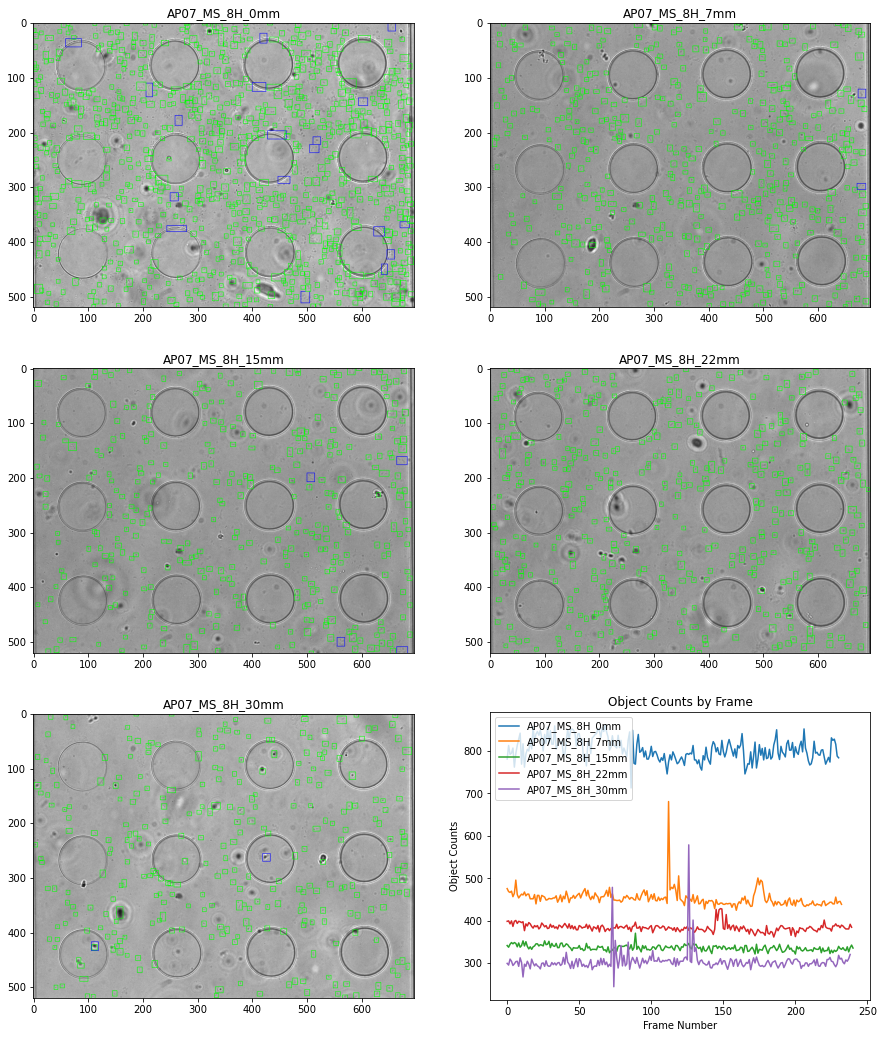

In [14]:
frame_choice = 35

plt.figure(figsize=(15,18))

plt.subplot(3,2,1)
plt.title(ds_titles[0])
plt.imshow(box_vids[0][frame_choice,:,:,:], cmap='gray')

plt.subplot(3,2,2)
plt.title(ds_titles[1])
plt.imshow(box_vids[1][frame_choice,:,:,:], cmap='gray')

plt.subplot(3,2,3)
plt.title(ds_titles[2])
plt.imshow(box_vids[2][frame_choice,:,:,:], cmap='gray')
    
plt.subplot(3,2,4)
plt.title(ds_titles[3])
plt.imshow(box_vids[3][frame_choice,:,:,:], cmap='gray')   

plt.subplot(3,2,5)
plt.title(ds_titles[4])
plt.imshow(box_vids[4][frame_choice,:,:,:], cmap='gray') 

plt.subplot(3,2,6)
plt.title('Object Counts by Frame')
plt.plot(object_counts[0], label = dsets[0].title)
plt.plot(object_counts[1], label = dsets[1].title)
plt.plot(object_counts[2], label = dsets[2].title)
plt.plot(object_counts[3], label = dsets[3].title)
plt.plot(object_counts[4], label = dsets[4].title)

plt.legend(loc = 'upper left')
plt.xlabel('Frame Number')
plt.ylabel('Object Counts')

#plt.savefig("/Volumes/MK_Device_4/FiguresOutput/dset_"+dsets[0].metadata['Species']\
        #+'_'+dsets[0].metadata['Media']+'_'+directory+'.png', dpi='figure', format='png')

plt.show()

In [11]:
data = {'Dataset': ds_titles,'Filename': filenames, \
     'Min':min_obj_count,'Max':max_obj_count,'Average':average_obj_count\
       ,'% Area Coverage':AverageAreaCovs}

df = pd.DataFrame(data)
df

,Dataset,Filename,Min,Max,Average,% Area Coverage
0,AP07_MS_8H_0mm,Channel_3_0.avi,713,861,803,5
1,AP07_MS_8H_7mm,Channel_3_7_5.avi,425,681,453,2
2,AP07_MS_8H_15mm,Channel_3_15.avi,322,371,336,1
3,AP07_MS_8H_22mm,Channel_3_22_5.avi,362,429,384,1
4,AP07_MS_8H_30mm,Channel_3_30.avi,245,579,304,4


In [12]:
mask_vids[0][:,:,:].shape

(231, 520, 696)